In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from dataloaders import FacadesDataset

## Neural architecture

In [3]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super(DownBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [4]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class GeneratorUNet(nn.Module):
    def __init__(self, input_nc, output_nc):
        """
        :param input_nc: input image channels
        :param output_nc: output image channels
        """
        super(GeneratorUNet, self).__init__()
        # Encoder (downsampling)
        self.down1 = DownBlock(input_nc, 64, normalize=False)  # без BatchNorm
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)
        self.down5 = DownBlock(512, 512)
        self.down6 = DownBlock(512, 512)
        self.down7 = DownBlock(512, 512)
        self.down8 = DownBlock(512, 512, normalize=False)
        
        # Decoder (upsampling) with skip connections
        self.up1 = UpBlock(512, 512, dropout=0.5)
        self.up2 = UpBlock(1024, 512, dropout=0.5)
        self.up3 = UpBlock(1024, 512, dropout=0.5)
        self.up4 = UpBlock(1024, 512)
        self.up5 = UpBlock(1024, 256)
        self.up6 = UpBlock(512, 128)
        self.up7 = UpBlock(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)  # размер: 128x128
        d2 = self.down2(d1) # 64x64
        d3 = self.down3(d2) # 32x32
        d4 = self.down4(d3) # 16x16
        d5 = self.down5(d4) # 8x8
        d6 = self.down6(d5) # 4x4
        d7 = self.down7(d6) # 2x2
        d8 = self.down8(d7) # 1x1
        
        # Decoder
        u1 = self.up1(d8)
        u1 = torch.cat([u1, d7], 1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d6], 1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d5], 1)
        u4 = self.up4(u3)
        u4 = torch.cat([u4, d4], 1)
        u5 = self.up5(u4)
        u5 = torch.cat([u5, d3], 1)
        u6 = self.up6(u5)
        u6 = torch.cat([u6, d2], 1)
        u7 = self.up7(u6)
        u7 = torch.cat([u7, d1], 1)
        output = self.final(u7)
        return output

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, output_nc):
        """
        Discriminator, recieves concatenation of a photo and mask (6 channels).
        :param input_nc: mask channels (3)
        :param output_nc: image channels (3)
        """
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc + output_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        
    def forward(self, input_img, target_img):
        x = torch.cat([input_img, target_img], dim=1)
        return self.model(x)

### Training

In [7]:
def train():
    # Гиперпараметры
    epochs = 200
    save_each = 50
    batch_size = 10
    lr = 0.0002
    beta1 = 0.5
    lambda_L1 = 100  # loss weight L1 (as in the original pix2pix work)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Используем устройство:", device)
    
    # Transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Uploading the training dataset
    train_dataset = FacadesDataset(root_dir='facades/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Creating a directory for checkpoints, if there is none
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    
    netG = GeneratorUNet(input_nc=3, output_nc=3).to(device)
    netD = Discriminator(input_nc=3, output_nc=3).to(device)
    
    # Loss function
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()
    
    # Optimizers
    optimizer_G = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    
    for epoch in range(epochs):
        for i, (mask, photo) in enumerate(train_loader):
            mask = mask.to(device)
            photo = photo.to(device)
            
            # Discriminator Training
            netD.zero_grad()
            # Real couples: (mask, photo)
            pred_real = netD(mask, photo)
            target_real = torch.ones_like(pred_real, device=device)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            # Fake couples: (mask, generated photo)
            fake_photo = netG(mask)
            pred_fake = netD(mask, fake_photo.detach())
            target_fake = torch.zeros_like(pred_fake, device=device)
            loss_D_fake = criterion_GAN(pred_fake, target_fake)
            
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()
            
            # Generator Training
            netG.zero_grad()

            pred_fake = netD(mask, fake_photo)
            loss_G_GAN = criterion_GAN(pred_fake, target_real)

            loss_G_L1 = criterion_L1(fake_photo, photo) * lambda_L1
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            optimizer_G.step()
            
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(train_loader)}] "
                      f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")
        
        if (epoch + 1) % save_each == 0:
            torch.save(netG.state_dict(), f'checkpoints/netG_epoch_{epoch+1}.pth')
            torch.save(netD.state_dict(), f'checkpoints/netD_epoch_{epoch+1}.pth')

In [8]:
train()

Используем устройство: cuda
Epoch [1/200] Batch [0/40] Loss_D: 0.7189, Loss_G: 74.0420
Epoch [2/200] Batch [0/40] Loss_D: 0.3100, Loss_G: 44.7452
Epoch [3/200] Batch [0/40] Loss_D: 0.0609, Loss_G: 40.9698
Epoch [4/200] Batch [0/40] Loss_D: 0.3866, Loss_G: 36.2877
Epoch [5/200] Batch [0/40] Loss_D: 0.2288, Loss_G: 41.1910
Epoch [6/200] Batch [0/40] Loss_D: 0.1495, Loss_G: 42.7919
Epoch [7/200] Batch [0/40] Loss_D: 0.2877, Loss_G: 36.5355
Epoch [8/200] Batch [0/40] Loss_D: 0.0819, Loss_G: 39.9460
Epoch [9/200] Batch [0/40] Loss_D: 0.0755, Loss_G: 36.7218
Epoch [10/200] Batch [0/40] Loss_D: 0.2314, Loss_G: 39.4662
Epoch [11/200] Batch [0/40] Loss_D: 0.2960, Loss_G: 33.2823
Epoch [12/200] Batch [0/40] Loss_D: 1.7261, Loss_G: 34.7733
Epoch [13/200] Batch [0/40] Loss_D: 1.0559, Loss_G: 33.2858
Epoch [14/200] Batch [0/40] Loss_D: 0.0928, Loss_G: 37.6941
Epoch [15/200] Batch [0/40] Loss_D: 0.2137, Loss_G: 35.0136
Epoch [16/200] Batch [0/40] Loss_D: 0.2099, Loss_G: 37.3339
Epoch [17/200] Batch 

### Results

In [14]:
def demonstrate_results(checkpoint_path, num_samples=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = FacadesDataset(root_dir='facades/test', transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    netG = GeneratorUNet(input_nc=3, output_nc=3).to(device)
    netG.load_state_dict(torch.load(checkpoint_path, map_location=device))
    netG.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, (mask, photo) in enumerate(dataloader):
        if i >= num_samples:
            break
        
        mask = mask.to(device)
        photo = photo.to(device)
        
        with torch.no_grad():
            fake_photo = netG(mask)
        
        mask_img = mask.squeeze(0).cpu() * 0.5 + 0.5
        photo_img = photo.squeeze(0).cpu() * 0.5 + 0.5
        fake_img = fake_photo.squeeze(0).cpu() * 0.5 + 0.5
        
        mask_np = mask_img.permute(1, 2, 0).numpy()
        photo_np = photo_img.permute(1, 2, 0).numpy()
        fake_np = fake_img.permute(1, 2, 0).numpy()
        
        axes[i][0].imshow(mask_np)
        axes[i][0].set_title("Маска (вход)")
        axes[i][0].axis("off")
        
        axes[i][1].imshow(photo_np)
        axes[i][1].set_title("Реальное фото")
        axes[i][1].axis("off")
        
        axes[i][2].imshow(fake_np)
        axes[i][2].set_title("Сгенерированное фото")
        axes[i][2].axis("off")
    
    plt.tight_layout()
    plt.show()

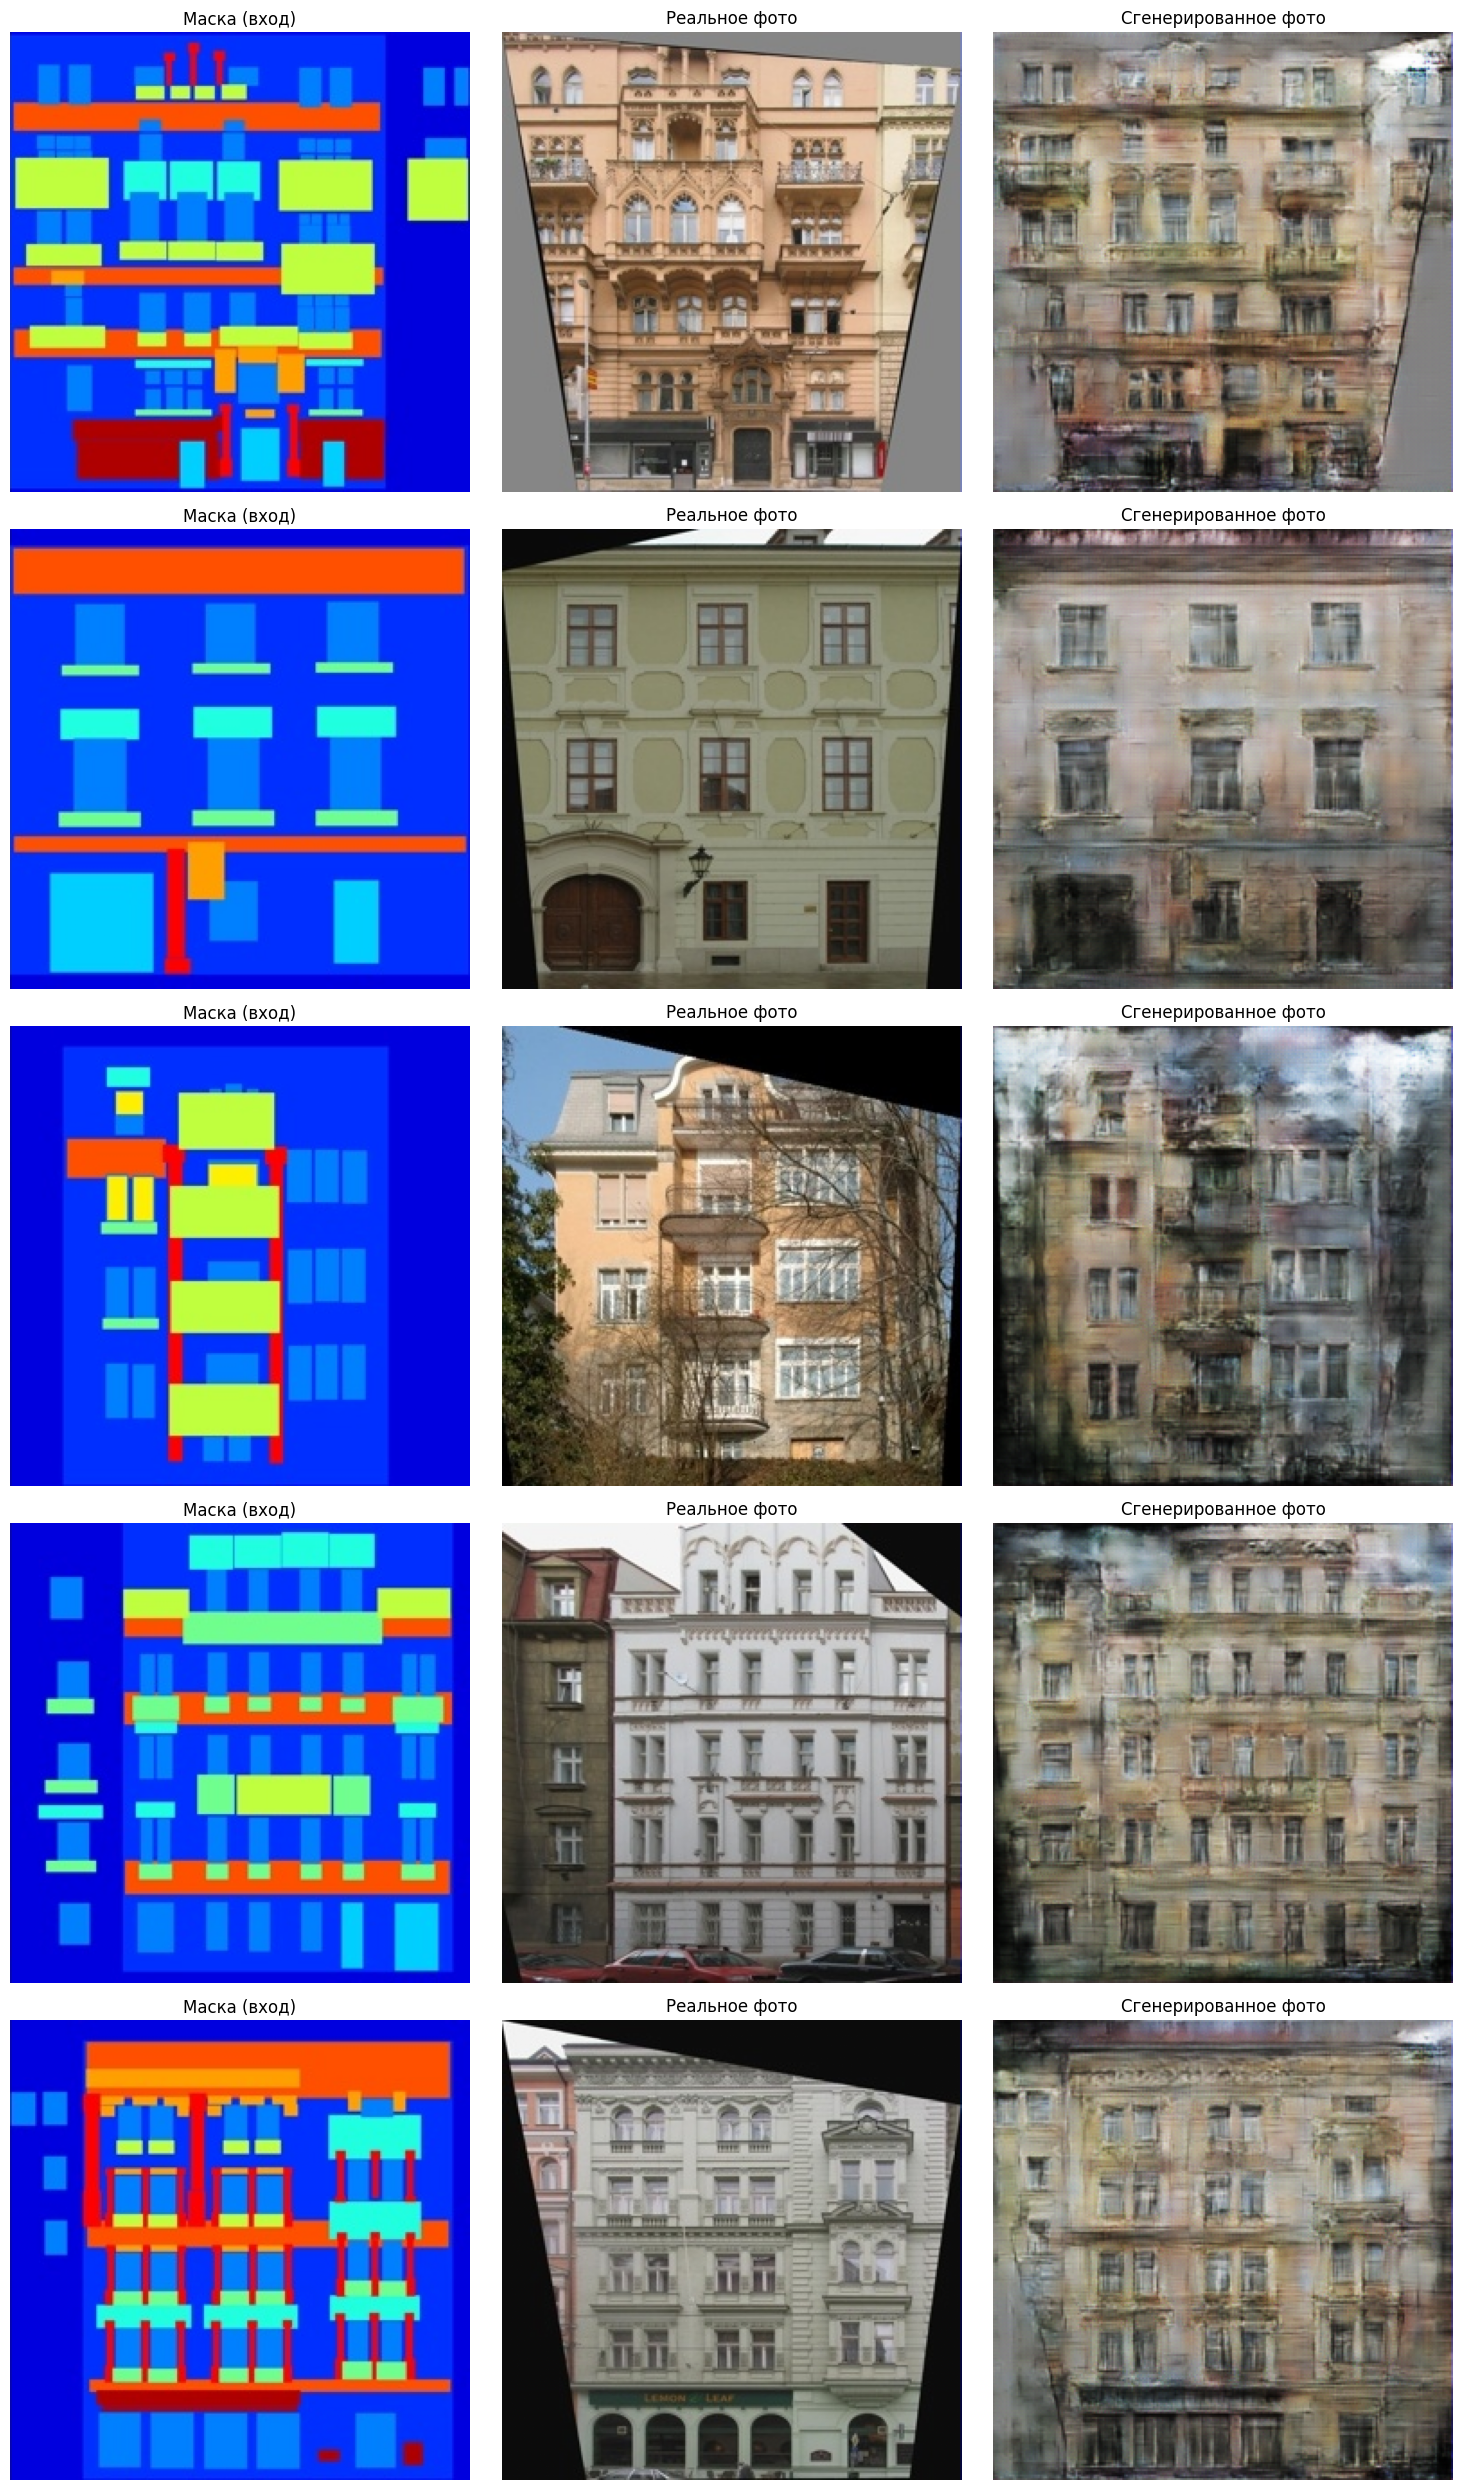

In [15]:
demonstrate_results("checkpoints/netG_epoch_200.pth", num_samples=5)

As you can see, the model copes with the generation of facades by mask, however, the images are obtained with a blur and contain artifacts. This is due to the addition of random noise during training.